## HOURLY ELECTRICITY PRICE FORECASTING MODEL

**Scope**

Develop a model based on LSTM Neural Networks for short-term electricity price forecasting.
The model can be fitted on any kind of regional price data downloaded from the North Pool website.
The baseline is a persistence model (explained in *BASELINE.ipynb* notebook). 

**Main Insights**
* LSTM for Time Series proved to be a good approach for this use case
* LSTM performance 2-5h ahead of actual market hour are far way better than persistence model performance

### REQUIRED LIBRARIES

In [1]:
# Import required libraries
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot as plt
import numpy
import os
import platform
import pickle

Using TensorFlow backend.


### REQUIRED FUNCTIONS

##### LOADING DATA

In [2]:
def load_data(params,years = ['2013','2014','2015','2016','2017']):
    """
    This function extracts annual datasets of hourly electricity price (source North Pool).
    
    Args:
        1) years -> list of dataset to be included in trainset and validationset
    Out:
        1) hourly electricity price dataset of the selected region
    """
    mkt = params['mkt']
    file_name_1 = params['path_to_file']['data_prefix']
    file_name_2 = params['path_to_file']['data_suffix']
    data_folder = params['path_to_file']['path_to_data']
    if platform.system()=='Linux':
        data_folder = os.getcwd().replace('notebook','data/')
    else:
        data_folder = os.getcwd().replace('notebook','data\\')
    
    all_data=[]
    for year in years:
        file_name_tot = data_folder + file_name_1 + year + file_name_2
        all_data.append(pd.read_csv(file_name_tot,encoding = "ISO-8859-1",sep=';',decimal=','))
    df = pd.concat(all_data, ignore_index=True,sort= True)
    df = df[['datetime','Hours',mkt]]
    return df

##### LSTM PREPROCESSING FUNCTIONS

In [3]:
def timeseries_to_supervised(data, lag=1):
    """
    This function frames a sequence as a supervised learning problem
    
    Args:
        1) data --> time series
        2) lag --> number of lagged features to be generated
    Out:
        1) df -> dataframe containing all the lagged features (from the more recent to the more lagged)
                 the last column of the dataframe is the initial time series (target of the supervised learning model)
    
    Lagged features are generated as continous in time. Id est, if 3 is the number of lagged features and t is the actual time, 
    generated features will be the actual series lagged at t-1, t-2, t-3
    """
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    #df = df.dropna()
    return df

def difference(dataset, interval=1):
    """
    This function create a differenced series to remove seasonality effects
    
    Args:
        1) dataset -> time series
    Out:
        1) Pandas Series of the differenced initial dataframe
    """
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset.iloc[i] - dataset.iloc[i - interval]
        diff.append(value)
    return Series(diff)

def inverse_difference(history, yhat, interval):
    """
    This function invert differenced values.
    
    Args:
        1) history -> time series to be predicted
        2) yhat -> predicted value
        3) interval -> difference interval
    
    Out:
        1) Anti-transformed predicted value
    """
    return yhat + history.iloc[-interval]


##### SCALER FUNCTIONS

In [4]:
def scale_fit(dataset, scaler=MinMaxScaler(feature_range=(-1, 1))):
    """
    Fit a scaler on a dataset
    
    Args:
        1) dataset --> train dataset
        2) scaler --> scaler to be fitted
        
    Out:
        1) scaler -> fitted scaler
    """
    
    # fit scaler
    scaler = scaler.fit(dataset)
    
    return scaler

def scale_transform(dataset, scaler):
    """
    Apply fitted scaler to a dataset
    
    Args:
        1) dataset to be transformed
        2) scaler (alreasy fitted)
        
    Out:
        1) fitted dataset
    """
    dataset = dataset.reshape(dataset.shape[0], dataset.shape[1])
    dataset_scaled = scaler.transform(dataset)
    
    return dataset_scaled


def invert_scale(scaler, X, value):
    """
    This function performs inverse scaling for a forecasted value
    
    Args:
        1) scaler -> fitted scaler with scale() function
        2) X -->
        3) value -->
    Out:
        1) unscaled value
    """
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

##### LSTM MODEL FUNCTIONS

In [5]:
def split_features_label(dataset):
    """
    This function splits datafrema in label and features
    
    Args:
        1) dataset -> input dataset, target variable is the last column
    Out:
        1) features -> model features matrix
        2) label -> supervised model label array
    
    IMPORTANT: assumptions about labels:
        1) Only one output (forecast at time t+n, when n is the number of steps ahead)
        2) label array must be the last column of the dataset matrix
        
    """
    features, label = dataset[:, 0:-1], dataset[:, -1]
    features = features.reshape(features.shape[0], 1, features.shape[1])
    return features,label

def fit_lstm(train, val, batch_size, nb_epoch, neurons):
    """
    This function fits an LSTM network to training data
    
    Args:
        1) train --> training dataset
        2) val --> validation dataset
        3) batch_size
        4) nb_epochs --> number of epochs
        5) neurons --> number of neurons in the hidden layer
    
    Out:
        1) model --> trained model
    """
    X, y = split_features_label(train)
    X_val, y_val = split_features_label(val)
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in tqdm_notebook(range(nb_epoch),leave=False):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False, validation_data=(X_val,y_val))
        model.reset_states()
    return model

def forecast_lstm(model, batch_size, X):
    """
    This function makes a one-step forecast
    
    Args:
        1) model --> supervised model (fitted by fit_lstm function)
        2) batch_size
        3) X --> input features
    """
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]


### INPUT PARAMETERS

Model parameters are provided as a dict, so that every function/class is independent from input type. 
Any change can be easily made using a config file where the user can modify dict values. 

In [6]:
params = {
    'mkt': 'Bergen',
    'path_to_file' : {
        'path_to_pickle' : '../saved_session/',
        'pickle_name' : 'electric_mkt_data.pkl',
        'path_to_data' : '../data/',
        'data_prefix' : 'elspot-prices_',
        'data_suffix' : '_hourly_dkk.csv'
    },
    'dataset' : {
        'val_share' : 0.2,
        'n_steps' : 24,
        'time_ahead' : 1
    },
    'arch' : {
        'n_ensemble' : 1,
        'neurons' : 5,
        'epochs' : 10,
        'batch_size': 1
    }
}

### ETL PIPELINE

1. Extract data from CSV files
2. Transform data to be consistent with LSTM input format
3. Split data into train and validation set
4. Dump data to pkl file

In [7]:
def etl_pipeline(params):
    
    # internal paramters for the LSTM model
    n_shift = params['dataset']['n_steps'] + params['dataset']['time_ahead'] - 1
    n_ahead = range(0,params['dataset']['time_ahead'])
    
    # data loading and feature extraction
    df = load_data(params)
    raw_values = df[params['mkt']].dropna()
    diff_values = difference(raw_values, interval = params['dataset']['time_ahead'])
    supervised = timeseries_to_supervised(diff_values, n_shift)
    supervised_values = supervised.values
    
    # train - validation split
    test_size = round(params['dataset']['val_share']*supervised_values.shape[0])
    train_size = supervised_values.shape[0]-test_size
    train, test = supervised_values[0:train_size,:], supervised_values[train_size:,:]
    if len(n_ahead)>0:
        train, test = np.delete(train, n_ahead, axis = 1),np.delete(test, n_ahead, axis = 1)
        
    # feature scaling
    scaler = scale_fit(train)
    train_scaled = scale_transform(train, scaler)
    test_scaled = scale_transform(test, scaler)
    
    # dump session
    pickle_file = params['path_to_file']['path_to_pickle']+params['path_to_file']['pickle_name']
    data = {'scaler': scaler, 
            'train_scaled': train_scaled, 
            'test_scaled': test_scaled, 
            'train': train, 
            'test': test,
            'raw_values': raw_values}
    with open(pickle_file, "wb") as f:
        pickle.dump(data, f)
    
    return

In [8]:
etl_pipeline(params)

### LSTM MODEL

1. Load data coming from the ETL process
2. fit an LSTM (or an ensemble of models)

In [9]:
pickle_file = params['path_to_file']['path_to_pickle']+params['path_to_file']['pickle_name']
with open(pickle_file, "rb") as f:
    saved_data = pickle.load(f)

In [10]:
# fit the model
lstm_ensemble = list()
for n in tqdm_notebook(range(params['arch']['n_ensemble'])):
    lstm_model = fit_lstm(saved_data['train_scaled'], 
                          saved_data['test_scaled'], 
                          params['arch']['batch_size'], 
                          params['arch']['epochs'], 
                          params['arch']['neurons'])
    lstm_ensemble.append(lstm_model)

### MODEL PERFORMANCE 

1. Predict electricity price (validation set)
2. Use performance metrics to assess model behaviour

In [11]:
def make_predictions(lstm_model,test_scaled,scaler,raw_values):
    """
    This function makes prediction on a test dataset using a fitted LSTM model
    
    Args:
        1) lstm_model -> fitted model
        2) test_scaled -> test dataset already preprocessed and scaled
        3) scaler --> required to unscale model input data
        4) raw_values --> required to undo time difference
    Out:
        1) predictions -> model forecasted values for the testset
    
    """
    
    # walk-forward validation on the test data
    predictions = list() 
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
    return predictions

In [12]:
def evaluate_model_performance(lstm_ensemble, test_scaled, raw_values, scaler):
    """
    This function estimates model performance, calculating relevant metrics
    
    Args:
        1) lstm_ensemble --> a list of models to be evaluated
        2) test_scaled --> test set to be used for metrics calculation
        3) raw_values --> inital unscaled dataset for benchmark
        4) scaler --> fitted scaler (necessary to unscale model input data)
        
    Out:
        1) rmse_ensemble --> a list of RMSE (one for each model)
        2) mae_ensemble --> a list of MAE (one for each model)
        3) predictions_ensemble --> a list of predicted values (one for each model)
    
    This function supports the evaluation of a single model (one-item list)
    
    """
    rmse_ensemble = list()
    mae_ensemble = list()
    predictions_ensemble = list()
    test_samples = test_scaled.shape[0]
    for i in tqdm_notebook(range(len(lstm_ensemble))):
        predictions = make_predictions(lstm_ensemble[i],test_scaled, scaler,raw_values)
        predictions_ensemble.append(predictions)
        rmse = sqrt(mean_squared_error(raw_values[-test_samples:], predictions))
        rmse_ensemble.append(rmse)
        mae = mean_absolute_error(raw_values[-test_samples:], predictions)
        mae_ensemble.append(mae)
    return rmse_ensemble, mae_ensemble, predictions_ensemble    

In [13]:
rmse_ensemble, mae_ensemble, predictions_ensemble = evaluate_model_performance(lstm_ensemble, 
                                                                               saved_data['test_scaled'], 
                                                                               saved_data['raw_values'],
                                                                               saved_data['scaler'])

In [14]:
def print_performance_metrics(rmse_ensemble,mae_ensemble):
    if len(rmse_ensemble)==len(mae_ensemble):
        if len(rmse_ensemble)>1:
            rmse = np.mean(np.array(rmse_ensemble))
            std_rmse = np.std(np.array(rmse_ensemble))
            mae = np.mean(np.array(mae_ensemble))
            std_mae = np.std(np.array(mae_ensemble))
            msg = 'AVG RMSE: {} STD RMSE: {} \n AVG MAE: {} STD MAE: {}'
            print(msg.format(rmse,std_rmse,mae,std_mae))
        else:
            msg = 'RMSE: {} \n MAE: {}'
            rmse = rmse_ensemble[0]
            mae = mae_ensemble[0]
            print(msg.format(rmse,mae))
    else:
        print('Array size mismatch!')
    return rmse, mae

In [15]:
rmse, mae =  print_performance_metrics(rmse_ensemble,mae_ensemble)

RMSE: 10.565158336221765 
 MAE: 4.132330267317212


### DATA VISUALIZATION

Show examples of model output

In [16]:
def plot_sample_predictions(predictions_ensemble,n_model=0,n_day=7):
    """
    This function plots observed vs predicted values for a fixed period of time
    
    Args:
        1) predictions_ensemble --> a list of predictions (one for each model)
        2) n_model --> which model of the ensemble is selected
        3) n_day --> how many days are plotted
    
    The function returns a matplotlib line plot
    """
    subset= 24*n_day
    model_predictions = predictions_ensemble[n_model]
    
    plt.figure(figsize=(15,7))
    plt.title('Model results on validation set')
    plt.xlabel('Time [Hours]')
    plt.ylabel('Electricity Price [DKK]')
    plt.plot(range(subset),raw_values[-subset:],color = 'b')
    plt.plot(range(subset),model_predictions[-subset:], color = 'r')
    plt.legend(['real','forecast'])
    plt.show()
    return

NameError: name 'raw_values' is not defined

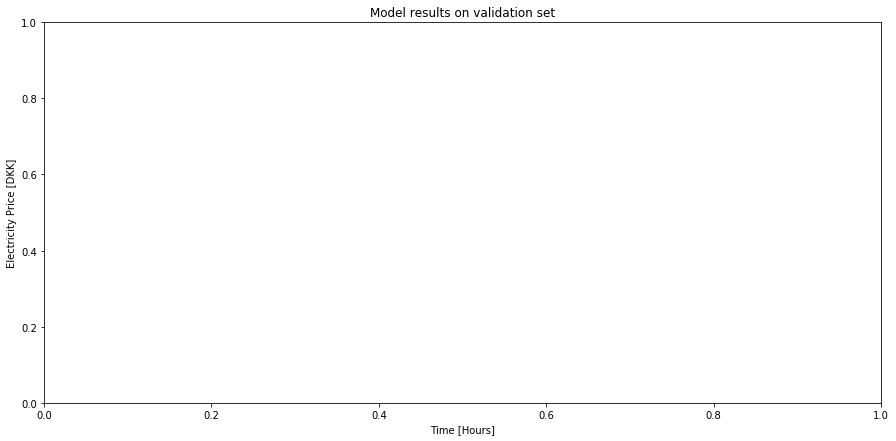

In [17]:
plot_sample_predictions(predictions_ensemble)

## FORECAST HORIZON IMPACT ON MODEL PERFORMANCE

In [ ]:
t_try = 24
rmse_list = list()
mae_list = list()

In [ ]:
for t in tqdm_notebook(range(t_try)):
    
    params['dataset']['time_ahead'] = t

    etl_pipeline(params)

    pickle_file = params['path_to_file']['path_to_pickle']+params['path_to_file']['pickle_name']
    with open(pickle_file, "rb") as f:
        saved_data = pickle.load(f)
    
    # fit the model
    lstm_ensemble = list()
    for n in tqdm_notebook(range(params['arch']['n_ensemble'])):
        lstm_model = fit_lstm(saved_data['train_scaled'], 
                              saved_data['test_scaled'], 
                              params['arch']['batch_size'], 
                              params['arch']['epochs'], 
                              params['arch']['neurons'])
        lstm_ensemble.append(lstm_model)

    # validation set
    rmse_ensemble, mae_ensemble, predictions_ensemble = evaluate_model_performance(lstm_ensemble, 
                                                                                   saved_data['test_scaled'], 
                                                                                   saved_data['raw_values'],
                                                                                   saved_data['scaler'])

    rmse, mae =  print_performance_metrics(rmse_ensemble,mae_ensemble)
    
    msg = 'model: time lag {}h, RMSE: {},MAE: {}'
    print(msg.format(t, rmse, mae))
    rmse_list.append(rmse)
    mae_list.append(mae)

In [ ]:
df_lstm_performance = pd.DataFrame({'lag':range(24),'rmse':rmse_list,'mae':mae_list})
df_lstm_performance.head()

In [58]:
results_pickle = params['path_to_file']['path_to_pickle']+'lstm_results.pkl'
with open(results_pickle, "wb") as f:
    pickle.dump(df_lstm_performance, f)